In [1]:
import sys
sys.path.append('../code/') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from scipy.signal import savgol_filter
from functools import partial

#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
device = torch.device('cpu')


torch.backends.cudnn.benchmark = True

2023-02-15 10:15:17.864884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 10:15:18.841225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 10:15:18.841446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 10:15:18.913406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-15 10:15:20.391055: W tensorflow/stream_executor/platform/de

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')
num_trials = metadata['num_trials']

# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))
notask_kinematic_df = kinematic_df[np.logical_and(nolayout_kinematic_mask, noposition_kinematic_mask)]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
neural_df = neural_df[np.logical_and(nolayout_neural_mask, noposition_neural_mask)]



#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
smooth_func = partial(savgol_filter, window_length=21, polyorder=3)
kinematic_df['posData'] = kinematic_df['posData'].map(smooth_func)
neural_df['rates'] = neural_df['rates'].map(smooth_func)

/tmp/ipykernel_4061/3780779201.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df[mask]['layout']


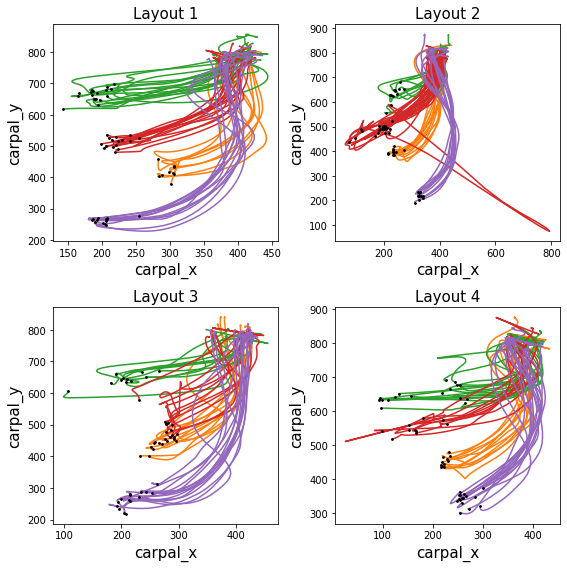

In [4]:
marker_name = 'carpal'

plt.figure(figsize=(8,8))
fontsize=15

avg_pos_dict = dict() # Store average marker position based on layout/position at trajectory end
for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(2,2,layout_idx)
        mask = np.logical_and(kinematic_df['position'] == position_idx, kinematic_df['layout'] == layout_idx)
        filtered_df = kinematic_df[mask]

        x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
        y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

        handpos_x = list()
        handpos_y = list()
        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

            handpos_x.append(plot_data[0][-1])
            handpos_y.append(plot_data[0][-1])

        avg_pos_dict[(position_idx, layout_idx)] = dict()
        avg_pos_dict[(position_idx, layout_idx)]['x'] = np.mean(handpos_x)
        avg_pos_dict[(position_idx, layout_idx)]['y'] = np.mean(handpos_y)


        filtered_df[mask]['layout']

        # plt.xlim(0, 600)
        # plt.ylim(0, 1000)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Layout {layout_idx}', fontsize=fontsize)

plt.tight_layout()
        

In [5]:
# Filter dataframes to separate object, body, and eye markers
proxjoint_markers = ['carpal', 'radiusDistal', 'ulnarDistal']
eye_markers = ['eye', 'cornea']
finger_markers = ['ring', 'pinky', 'thumb', 'index', 'middle']
proxjoint_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in proxjoint_markers])
finger_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in finger_markers])
eye_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in eye_markers])

nolayout_mask = ~(kinematic_df['name'].str.contains(pat='layout'))


# proxjoint_df = kinematic_df[proxjoint_mask]
# finger_df = kinematic_df[finger_mask]
# eyes_df = kinematic_df[eye_mask]

# finger_proxjoint_df = pd.concat([finger_df, proxjoint_df])
# nolayout_df = kinematic_df[nolayout_mask]


In [6]:
task_df = kinematic_df[np.logical_or.reduce([proxjoint_mask, ~noposition_kinematic_mask, ~nolayout_kinematic_mask])]
layout_df = kinematic_df[np.logical_or.reduce([proxjoint_mask, ~noposition_kinematic_mask])]
position_df = kinematic_df[np.logical_or.reduce([proxjoint_mask, ~nolayout_kinematic_mask])]

notask_df = kinematic_df[np.logical_and.reduce([noposition_kinematic_mask, nolayout_kinematic_mask])]
proxjoint_notask_mask = np.logical_or.reduce([notask_df['name'].str.contains(pat=pat) for pat in proxjoint_markers])
notask_df = notask_df[proxjoint_notask_mask]


In [44]:
#GRU architecture for decoding kinematics
class model_gru(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None):
        super(model_gru, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features
        self.input_size = input_size

        #Defining the layers
        # Fully connected layer
        if cat_features is not None:
            self.input_size = self.input_size - np.sum(self.cat_features).astype(int)
            self.fc = nn.Linear((self.hidden_dim + np.sum(self.cat_features))*num_directions, output_size)
        else:
            self.fc = nn.Linear(self.hidden_dim*num_directions, output_size)

        #Defining the layers
        self.gru = nn.GRU(self.input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional) 
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.gru(x[:, :, ~self.cat_features], hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous()
        if self.cat_features is not None:
            out = torch.cat([out, x[:, :, self.cat_features]], 2)
        #print(out.size())
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        #GRU initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)

        return hidden

In [45]:
# def make_generators(pred_df, neural_df, neural_offset, exclude_processing=None):
#     sampling_rate = 100
#     kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
#     offset = neural_offset + kernel_offset
#     window_size = 30
#     data_step_size = 1

#     # Set up PyTorch Dataloaders
#     fold=0
#     kinematic_type = 'posData'
#     scale_data = True
#     # Parameters
#     batch_size = 10000
#     train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
#     train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
#     validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
#     test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

#     predict_kinematics=False
#     # Generators
#     training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
#                                                 data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_kinematic = exclude_processing)
#     training_generator = torch.utils.data.DataLoader(training_set, **train_params)
#     training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
#     X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
#     y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

#     validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
#                                                     data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_kinematic = exclude_processing)
#     validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

#     testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
#                                                     data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_kinematic = exclude_processing)
#     testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
#     X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
#     y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

#     data_arrays = (training_set, validation_set, testing_set)
#     generators = (training_generator, training_eval_generator, validation_generator, testing_generator)

#     return data_arrays, generators 

### Use function to create train/test sets with each data frame

In [46]:
def run_wiener(pred_df, neural_df, neural_offset, task_info=True, window_size=10, num_cat=0):
  if task_info:
    exclude_processing = np.zeros(len(pred_df['name'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None
    
  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, 
    exclude_kinematics=exclude_processing, window_size=window_size, flip_outputs=False)

  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Fit and run wiener filter
  model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
  model_wr.fit(X_train_data,y_train_data)

  wr_train_pred = model_wr.predict(X_train_data)
  wr_test_pred = model_wr.predict(X_test_data)

  #Compute decoding
  wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
  wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

  return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_rnn(pred_df, neural_df, neural_offset, task_info=True, window_size=10, num_cat=0):
  if task_info:
    exclude_processing = np.zeros(len(pred_df['name'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None

  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_kinematics=exclude_processing,
    window_size=window_size, flip_outputs=False)
  
  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Define hyperparameters
  lr = 1e-2
  weight_decay = 1e-4
  hidden_dim = 100
  dropout = 0.5
  n_layers = 2
  max_epochs = 1000
  input_size = training_set[0][0].shape[1] 
  output_size = training_set[0][1].shape[1] 


  # model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
  model_rnn = model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

  # Define Loss, Optimizerints h
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

  #Train model
  loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
  rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

  return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr
    

### Generate decoding results

In [47]:
neural_offset = 20
window_size = 20

func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
# func_dict = {'wiener': run_wiener}

df_dict = {'layout': {'df': layout_df, 'task_info': True, 'num_cat': 4}, 
           'position': {'df': position_df, 'task_info': True, 'num_cat': 4}, 
           'task': {'df': task_df, 'task_info': True, 'num_cat': 8}, 
           'notask': {'df': notask_df, 'task_info': False, 'num_cat': 0}}
        #    'notask_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': False},
        #    'task_neural_eyes': {'df': notask_neural_eyes_df, 'task_info': True,}}
           #'eyes': {'df': eye_df, 'task_info': False}}

decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(pred_df['df'], neural_df, neural_offset, task_info=pred_df['task_info'],
                                                            window_size=window_size, num_cat=pred_df['num_cat'])
        #train_pred, test_pred, train_corr, test_corr = func(kinematic_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'])

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



TypeError: only integer scalar arrays can be converted to a scalar index

In [11]:
with open('decode_res.pkl', 'wb') as f:
    pickle.dump(decode_results, f)

In [12]:
# all_offset, proxjoint_offset, finger_offset, eyes_offset, finger_proxjoint_offset = 20, 20, 20, 20, 20

# func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
# # df_dict = {'all': kinematic_df, 'proxjoint': proxjoint_df, 'finger': finger_df, 'eyes': eyes_df, 'finger_proxjoint': finger_proxjoint_df,
# #            'no_layout': nolayout_df}
# df_dict = {'layout': {'df': kinematic_df, 'task_info': True}, 'notask': {'df': notask_kinematic_df, 'task_info': False}}

# decode_results = dict()
# for func_name, func in func_dict.items():
#     decode_results[func_name] = dict()
#     for df_type, pred_df in df_dict.items():
#         train_pred, test_pred, train_corr, test_corr = func(pred_df['df'], neural_df,20, task_info=pred_df['task_info'])

#         decode_results[func_name][df_type] = {
#             'train_pred': train_pred,
#             'test_pred': test_pred,
#             'train_corr': train_corr,
#             'test_corr': test_corr
#         }



In [35]:
decoder_type = 'rnn'
cond1 = 'notask'
cond2 = 'task'

(-0.2, 0.9)

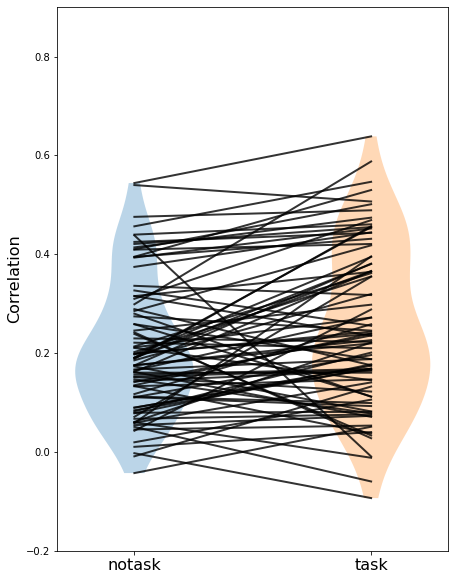

In [36]:
nolayout_test_corr = decode_results[decoder_type][cond1]['test_corr']
all_test_corr = decode_results[decoder_type][cond2]['test_corr']

plt.figure(figsize=(7,10))
plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=[cond1, cond2], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
# plt.title('All Marker Decoding', fontsize=16)
plt.ylim([-0.2,0.9])
# plt.savefig(f'movement_decoding_violin_{num_neurons}_neurons_layout.png')

KeyError: 'layout'

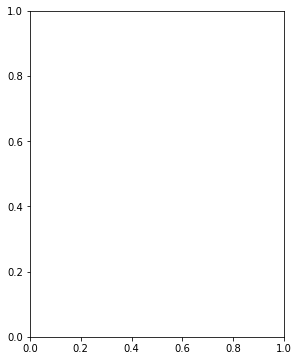

In [12]:
plt.figure(figsize=(10,6))
for idx, decoder_type in enumerate(['wiener', 'wiener']):
    plt.subplot(1,2,idx+1)
    nolayout_test_corr = decode_results[decoder_type]['notask']['test_corr']
    all_test_corr = decode_results[decoder_type]['layout']['test_corr']
    plot_data = np.stack([nolayout_test_corr, all_test_corr])
    _ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
    plt.xticks([0, 1], labels=['None', 'Lay+Pos'], fontsize=16)
    plt.ylabel('Correlation', fontsize=16)
    plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
    plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
    plt.title(f'{decoder_type} decoding', fontsize=16)
    plt.ylim([-0.05,0.9])

NameError: name 'proxjoint_test_corr' is not defined

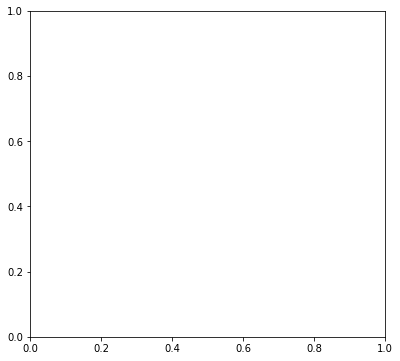

In [34]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.subplot(1,2,2)
plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.savefig('single_unit_pred_final.svg')

In [ ]:
compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

data_arrays, generators = make_generators(kinematic_df, neural_df, neural_offset=20)
    
# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

#Testing Data
plt.figure(figsize=(14,8))
bounds = np.arange(0,1500)
x_vals = np.arange(len(bounds))/100
unit_list = [4, 8, 16]

for row_idx, unit_idx in enumerate(unit_list):
    for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
        plt.subplot(3,4, plot_idx+1 + (4*row_idx))
        plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
        plt.ylim(plt.ylim())
        plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
        plt.title(f'{name}: Unit {unit_idx}')
        #plt.ylim([-3, 3.7])
        
        if plot_idx == 0:
            plt.ylabel('Firing Rate (a.u.)')
            
        if row_idx == 2:
            plt.xlabel('Time (s)')
        else:
            plt.xticks([])

    plt.tight_layout()